# 기계학습_중간고사_대체과제
**201920829 금동호** </br>
>본 과제에서는 공공데이터 포털 내 서울특별시의 상권들의 유동인구 수를 연령별로 집계한 **서울시 상권분석서비스(길단위인구-상권)** 데이터를 활용해 상권과 연령별 유동인구의 연관성을 알아보고자 한다.

### 환경 설정 및 원본 데이터 로드

In [1]:
%pip install imblearn
%pip install seaborn
%pip install yellowbrick

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 3.4 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.6/282.6 kB 4.6 MB/s eta 0:00:00:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
data0 = pd.read_csv("서울시 상권분석서비스(길단위인구-상권).csv", encoding='cp949' ) #파일 인코딩을 cp949로 지정

In [3]:
data0.head() # 불러온 데이터 확인 

,기준_년분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,총_유동인구_수,남성_유동인구_수,여성_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,...,시간대_14_17_유동인구_수,시간대_17_21_유동인구_수,시간대_21_24_유동인구_수,월요일_유동인구_수,화요일_유동인구_수,수요일_유동인구_수,목요일_유동인구_수,금요일_유동인구_수,토요일_유동인구_수,일요일_유동인구_수
0,20233,U,관광특구,3001496,강남 마이스 관광특구,116820,56546,60274,9741,24430,...,28982,24541,6292,16713,17686,18378,18560,18293,14662,12527
1,20233,U,관광특구,3001495,잠실 관광특구,4005509,1937145,2068365,413439,892838,...,633309,864839,465448,566137,566857,573760,570159,579731,595722,553142
2,20233,U,관광특구,3001494,종로?청계 관광특구,8353018,4439304,3913714,321655,1531086,...,1773540,1659889,647989,1344871,1344464,1353279,1316337,1316317,962386,715364
3,20233,U,관광특구,3001493,동대문패션타운 관광특구,3189182,1510236,1678946,173200,566457,...,480423,562444,384970,505715,509594,510428,496596,464684,354613,347552
4,20233,U,관광특구,3001492,명동 남대문 북창동 다동 무교동 관광특구,6822274,3317776,3504498,284079,1188425,...,1665421,1296312,342464,1117683,1129837,1153089,1116744,1090865,678392,535663


**데이터 전처리**

In [4]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt


#2023년의 4분기 데이터의 부재로 2022년의 1년간 데이터 추출
data1 = data0[(data0['기준_년분기_코드'] == 20221) | (data0['기준_년분기_코드'] == 20222) | (data0['기준_년분기_코드'] == 20223) | (data0['기준_년분기_코드'] == 20224)]
#총 유동인구수와 연령 별 유동 인구수 데이터 필터링
data = data1[['상권_코드_명', '총_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수']]
#데이터 확인
data.head()

,상권_코드_명,총_유동인구_수,연령대_10_유동인구_수,연령대_20_유동인구_수,연령대_30_유동인구_수,연령대_40_유동인구_수,연령대_50_유동인구_수,연령대_60_이상_유동인구_수
4947,강남 마이스 관광특구,113561,8423,23526,31283,25479,14310,10540
4948,잠실 관광특구,4179934,490222,895245,996787,695561,514816,587304
4949,종로?청계 관광특구,8657826,334742,1500979,1638219,1618642,1555937,2009307
4950,동대문패션타운 관광특구,3418870,182494,618819,818283,662903,526843,609528
4951,명동 남대문 북창동 다동 무교동 관광특구,7629595,365427,1301955,1839034,1667878,1216256,1239044


### 엘보우 방법을 통한 클러스터 개수 설정

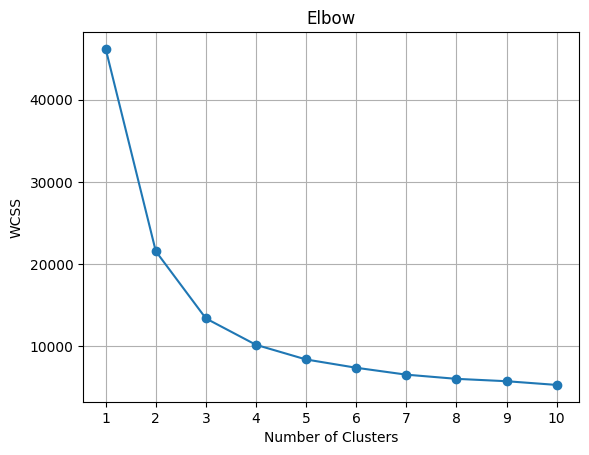

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

#클러스터링 할 변수 지정
selected = data[['총_유동인구_수', '연령대_10_유동인구_수', '연령대_20_유동인구_수', '연령대_30_유동인구_수', '연령대_40_유동인구_수', '연령대_50_유동인구_수', '연령대_60_이상_유동인구_수']]

#데이터 정규화를 통해 수치 조절
scaler = StandardScaler()
selected_scaled = scaler.fit_transform(selected)

# 적절한 k값을 찾기 위해 11개로 초기설정
k_values = range(1, 11)
wcss_values = []

# 1~10의 k 값으로 k-means 모델 학습 후 WCSS값 계산
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(selected_scaled)
    wcss_values.append(kmeans.inertia_)

# 1~10의 k 값에 따른 WCSS값 플롯
plt.plot(k_values, wcss_values, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()

위 그래프를 보면, **k 값이 4**일 때를 기준으로 기울기가 급감하고 있다. 따라서, 엘보우 방법을 통해 적절한 클러스터의 수는 4개임을 알 수 있다.

### 클러스터링 진행, 분석 및 평가

       총_유동인구_수  연령대_10_유동인구_수  연령대_20_유동인구_수  연령대_30_유동인구_수  연령대_40_유동인구_수  \
0  2.630159e+05   35433.060133   41677.673027   44583.764672   42901.158138   
1  1.986953e+06  253902.332636  355971.621339  355825.287657  317621.142259   
2  4.391629e+06  449864.896552  957159.643678  870218.155172  717696.522989   
3  9.629099e+05  130282.992537  161934.151741  162822.460199  153792.729353   

   연령대_50_유동인구_수  연령대_60_이상_유동인구_수  
0   39760.094247      58660.298352  
1  286466.093096     417166.637029  
2  595778.063218     800911.465517  
3  143408.609453     210669.014428  


/tmp/ipykernel_5141/1644021139.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cluster'] = clusters


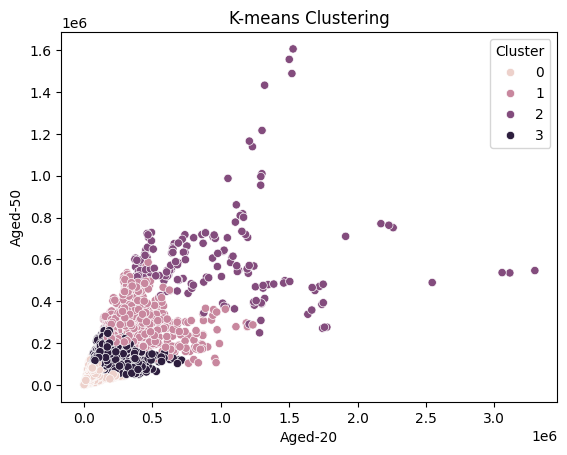

The average of silhouette score: 0.4794808796888576


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

# k=4 지정후 새로운 K-means 클러스터링 수행
kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit_predict(selected)

# 4개의 클러스터의 중심점을 계산 및 출력
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=selected.columns)
print(cluster_centers)

# 유의미한 비교를 위해 두 개의 비교값으로 20대와 50대를 선정, 20대와 50대의 비교 클러스터 시각화
data['Cluster'] = clusters
sns.scatterplot(x='연령대_20_유동인구_수', y='연령대_50_유동인구_수', hue='Cluster', data=data)
plt.title('K-means Clustering')
plt.xlabel('Aged-20')
plt.ylabel('Aged-50')
plt.show()

# 실루엣 점수 계산 및 출력
silhouette_avg = silhouette_score(selected_scaled, clusters)
print("The average of silhouette score:", silhouette_avg)

-1부터 1까지의 범위를 갖는 실루엣 점수가 약 0.47정도로 나왔다. 이는 클러스터링 결과가 월등히 좋다고는 할 수 없겠으나, 크게 잘못 분류되지는 않은 정도로 볼 수 있겠다.